In [26]:
import os
import sys
sys.path.append("../colorado/")
from scalebar import scale_bar

import rasterio as rio
from rasterio.io import MemoryFile
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio import plot

import geopandas as gpd
from shapely import geometry, ops

import cartopy.crs as ccrs



import numpy as np

import matplotlib.pyplot as plt

# Fig X: Comparing SCA Performance.

We want to capture in high-resolution the differences between **PS ML SCA, Sentinel-2 NDSI, LS8 fSCA, and ASO** in terms of resolution and vegetation-cover performance. 

I think we can do this in CO, but might also want to do this in Tuolumne. 

In [9]:
data_root = '/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/'
print(os.listdir(data_root))

['.DS_Store', 'ASO_3M_SD_USCATE_20180528', 'CO']


In [10]:
co_data_root = os.path.join(data_root, "CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/")
ca_data_root = os.path.join(data_root, "ASO_3M_SD_USCATE_20180528")

## Define a CO BBox

In [11]:
co_bbox = gpd.read_file("./co_zoom.geojson")
co_bbox['geometry'].to_list()

In [12]:
co_bbox.bounds.iloc[0]

minx   -107.078428
miny     39.051538
maxx   -107.060325
maxy     39.069641
Name: 0, dtype: float64

## File Loading

In [13]:
CO_comparatorFilenames_IMAGE = {
    'PS': os.path.join(co_data_root, "20180524_172637_0f2d_3B_Visual.tif"),
    'S2': os.path.join(data_root, "CO", "sentinel-2", "13SCD,2018-05-27,0", "B03.jp2"),
    'LS8': os.path.join(data_root, "CO", "LC08_CU_010009_20180526_20190615_C01_V01_SNOW", "LC08_CU_010009_20180526_20190615_C01_V01_SNOW.tif")
}

In [14]:
comparator_root = os.path.join(co_data_root, "32776e534dede28c6635a4f4a15f723a/coarsened")
CO_comparatorFilenames_SCA = {
    'PS' : os.path.join(comparator_root, "ASO_vs_20180524_172637_0f2d_3B_AnalyticMS_SR_clip_merged_clipped.vrt"),
    'S2' : os.path.join(comparator_root, "ASO_vs_NDSI-clipped-ls8_reprojected_clipped_clipped.vrt"),
    'LS8': os.path.join(comparator_root, "ASO_vs_LC08_CU_010009_20180526_20190615_C01_V01_SNOW_05_convex_reprojected_clipped.vrt")
}

## TEst with 1

In [15]:
co_sca = rio.open(CO_comparatorFilenames_SCA['LS8'])

In [16]:
co_sca_cropped, co_sca_transform = mask(co_sca, co_bbox.to_crs(crs=co_sca.crs).geometry.to_list(), crop=True, nodata=-9999)
co_sca_cropped = np.ma.MaskedArray(co_sca_cropped, mask=(co_sca_cropped == -9999))
co_sca_extent=plot.plotting_extent(co_sca_cropped[0], transform=transform)

NameError: name 'transform' is not defined

In [238]:
co_sca_extent

(-107.07843302371626, -107.07732735482902, 39.0685195151049, 39.06964525894658)

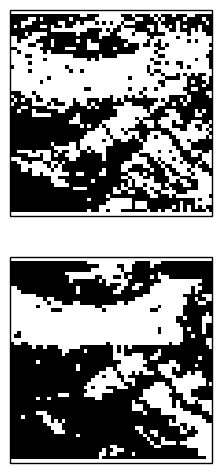

In [239]:
fig, axes = plt.subplots(2, 1, figsize=(3, 6), dpi=100, subplot_kw=dict(projection=ccrs.PlateCarree()))
axes[0].set_extent(co_sca_extent, crs=ccrs.PlateCarree())
axes[0].imshow(co_sca_cropped[0], extent=co_sca_extent, origin='upper', transform=ccrs.PlateCarree(), cmap='binary_r')
axes[1].set_extent(co_sca_extent, crs=ccrs.PlateCarree())
axes[1].imshow(co_sca_cropped[1], extent=co_sca_extent, origin='upper', transform=ccrs.PlateCarree(), cmap='binary_r')

In [374]:
co_image = rio.open(CO_comparatorFilenames_IMAGE['LS8'])
# image_crs_cp = ccrs.epsg(co_image.crs.to_dict()['init'].split(":")[1])


In [243]:
co_image_cropped, co_image_transform = mask(co_image, co_bbox.to_crs(crs=co_image.crs).geometry.to_list(), crop=True, nodata=co_image.nodata)
co_image_cropped = np.ma.MaskedArray(co_image_cropped, mask=(co_image_cropped == -9999))
co_image_extent=plot.plotting_extent(co_s2_cropped[0], transform=transform)

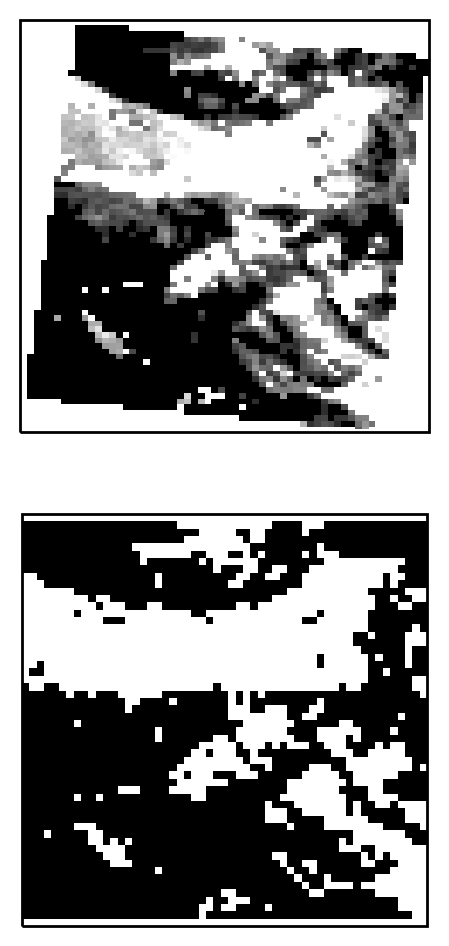

In [244]:
fig, axes = plt.subplots(2, 1, figsize=(3, 6), dpi=200, subplot_kw=dict(projection=ccrs.PlateCarree()))
axes[0].set_extent(co_image_extent, crs=image_crs_cp)
axes[0].imshow(co_image_cropped[0], extent=co_image_extent, origin='upper', transform=image_crs_cp, cmap='binary_r')
axes[1].set_extent(co_sca_extent, crs=ccrs.PlateCarree())
axes[1].imshow(co_sca_cropped[1], extent=co_sca_extent, origin='upper', transform=ccrs.PlateCarree(), cmap='binary_r')

In [111]:
ccrs.epsg(co_image.crs.to_dict()['init'].split(":")[1])

_EPSGProjection(32613)

In [108]:
co_image.crs.to_dict()

{'init': 'epsg:32613'}

In [336]:
src.dtypes[0]

'int16'

In [27]:
src = co_image
dst_xform, dst_w, dst_h = calculate_default_transform(src.crs, {'init': 'epsg:4326'}, src.width, src.height, *src.bounds)
data = src.read()


profile = {
    'driver' : 'GTiff',
    'dtype' : src.dtypes[0],
    'height' : dst_h,
    'width' : dst_w,
    'count' : src.count,
    'crs' : {'init' : 'epsg:4326'},
    'transform' : dst_xform
}


reproj_file = MemoryFile()


with rio.open(reproj_file, 'w', **profile) as dst:

    for i, band in enumerate(data, 1):
        print(band.shape)
        dest = np.zeros((dst_h, dst_w))
        
        reproject(
            band,
            rio.band(dst, i),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=dst_xform,
            dst_crs=src.crs,
            resampling=Resampling.bilinear)
        


        
reproj_file.seek(0)

NameError: name 'co_image' is not defined

In [376]:
co_image = reproj_file.open()

In [377]:

co_image_cropped, co_image_transform = mask(co_image, co_bbox.to_crs(crs=co_image.crs).geometry.to_list(), crop=True, nodata=co_image.nodata)
co_image_cropped = np.ma.MaskedArray(co_image_cropped, mask=(co_image_cropped == -9999))
co_image_extent=plot.plotting_extent(co_s2_cropped[0], transform=transform)

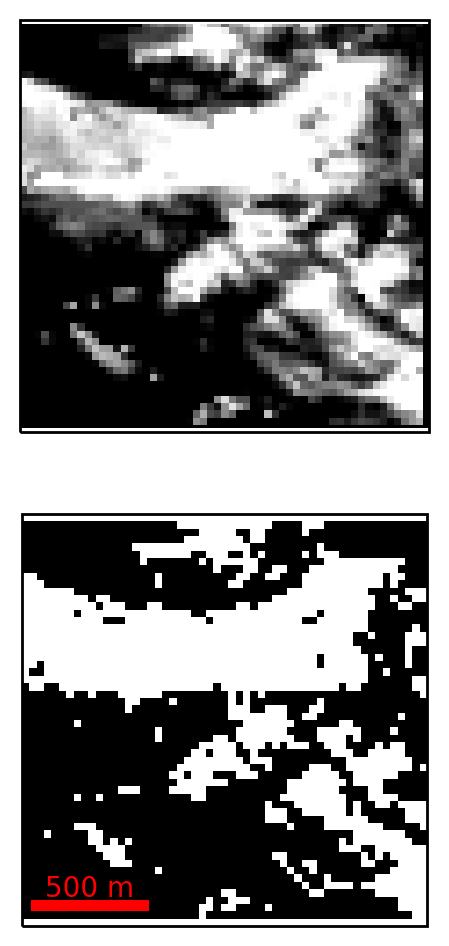

In [534]:
fig, axes = plt.subplots(2, 1, figsize=(3, 6), dpi=200, subplot_kw=dict(projection=ccrs.PlateCarree()))
axes[0].set_extent(co_image_extent, crs=image_crs_cp)
axes[0].imshow(co_image_cropped[0], extent=co_image_extent, origin='upper', transform=image_crs_cp, cmap='binary_r')
axes[1].set_extent(co_sca_extent, crs=ccrs.PlateCarree())
axes[1].imshow(co_sca_cropped[1], extent=co_sca_extent, origin='upper', transform=ccrs.PlateCarree(), cmap='binary_r')

scale_bar(axes[1], (0.035, 0.05), 500, metres_per_unit=0.05, unit_name='m', color='red', linewidth=4)

In [33]:
def _reproject(image):
    src = image
    dst_xform, dst_w, dst_h = calculate_default_transform(src.crs, {'init': 'epsg:4326'}, src.width, src.height, *src.bounds)
    data = src.read()
    profile = {
        'driver' : 'GTiff',
        'dtype' : src.dtypes[0],
        'height' : dst_h,
        'width' : dst_w,
        'count' : src.count,
        'crs' : {'init' : 'epsg:4326'},
        'transform' : dst_xform
    }

    reproj_file = MemoryFile()
    with rio.open(reproj_file, 'w', **profile) as dst:

        for i, band in enumerate(data, 1):
            dest = np.zeros((dst_h, dst_w))

            reproject(
                band,
                rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_xform,
                dst_crs=src.crs,
                resampling=Resampling.bilinear)



    reproj_file.seek(0)
    return(reproj_file.open())
        


In [34]:
def single_column_plot(sca_file, image_file, image_band, bbox, axes = None):
    image = rio.open(image_file)
    sca = rio.open(sca_file)
    
    epsg = image.crs.to_epsg()
    if epsg != 4326:
        print('Projection Required')
        image = _reproject(image)

    image_cropped, image_transform = mask(image, bbox.to_crs(crs=image.crs).geometry.to_list(), crop=True, nodata=image.nodata)
    image_cropped = np.ma.MaskedArray(image_cropped, mask=(image_cropped == image.nodata))
    image_extent =plot.plotting_extent(image_cropped[0], transform=image_transform)
    
    sca_cropped, sca_transform = mask(sca, bbox.to_crs(crs=sca.crs).geometry.to_list(), crop=True, nodata=-9999)
    sca_cropped = np.ma.MaskedArray(sca_cropped, mask=(sca_cropped == -9999))
    sca_extent = plot.plotting_extent(sca_cropped[0], transform=sca_transform)
    
    image_crs_cp = ccrs.epsg(32613) ## HARD CODED ! 

    if type(axes) == 'NoneType':
        fig, axes = plt.subplots(2, 1, figsize=(3, 6), dpi=200, subplot_kw=dict(projection=ccrs.PlateCarree()))
    
    axes[0].set_extent(image_extent, crs=image_crs_cp)
    axes[0].imshow(image_cropped[image_band], extent=image_extent, origin='upper', transform=image_crs_cp, cmap='binary_r')
    axes[1].set_extent(sca_extent, crs=ccrs.PlateCarree())
    axes[1].imshow(sca_cropped[1], extent=sca_extent, origin='upper', transform=ccrs.PlateCarree(), cmap='binary_r')

Projection Required


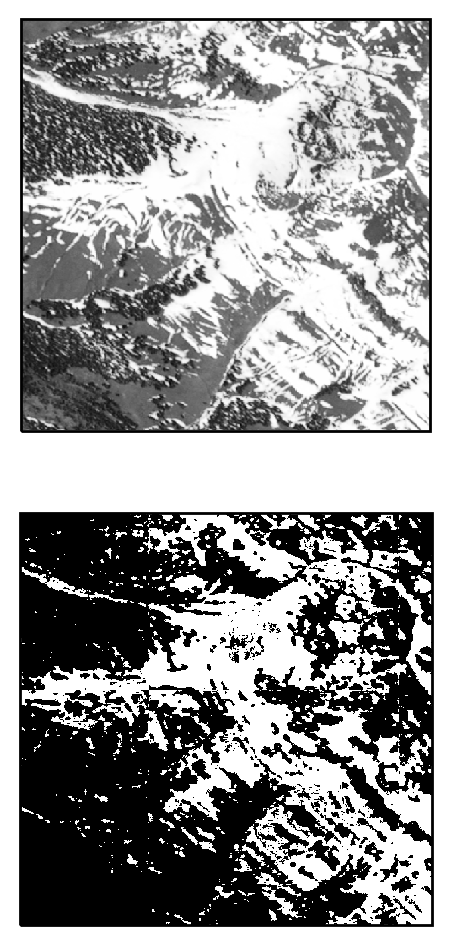

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(3, 6), dpi=200, subplot_kw=dict(projection=ccrs.PlateCarree()))
single_column_plot(CO_comparatorFilenames_SCA['PS'], CO_comparatorFilenames_IMAGE['PS'],2,  co_bbox, axes=axes, )

Projection Required
Projection Required
Projection Required


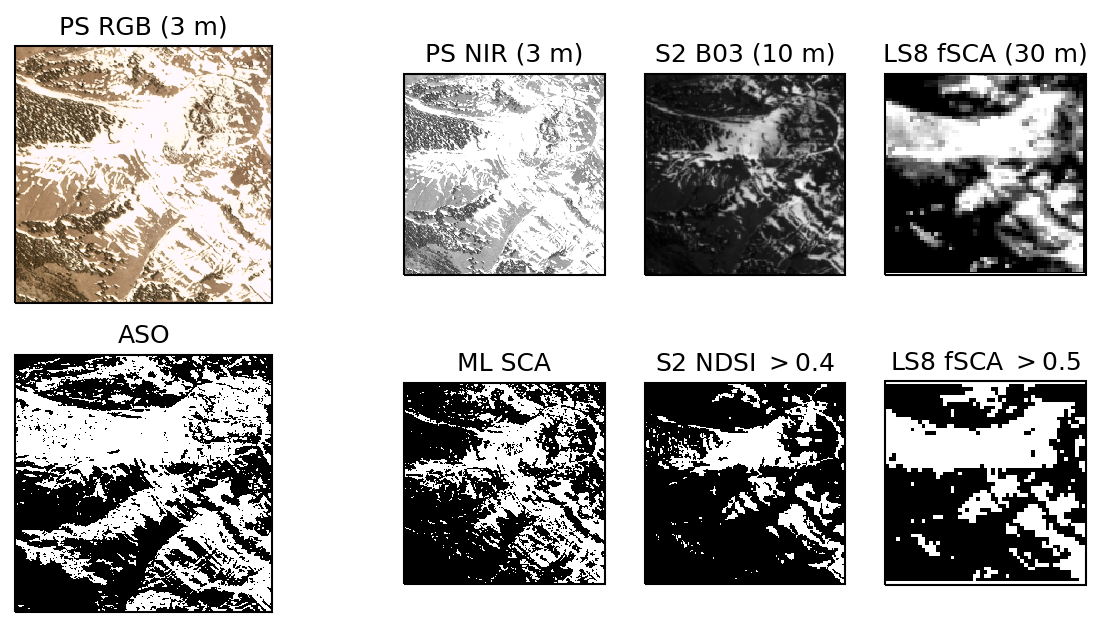

In [58]:
fig = plt.figure(figsize=(10, 5), dpi=150)
gs = plt.GridSpec(2, 5, figure=fig)

ps_axes = fig.add_subplot(gs[0, :2], projection=ccrs.PlateCarree())
aso_axes = fig.add_subplot(gs[1, :2], projection=ccrs.PlateCarree())


aso_image = rio.open(CO_comparatorFilenames_SCA['PS']) # arbitrary
aso_image_cropped, aso_image_transform = mask(aso_image, co_bbox.to_crs(crs=aso_image.crs).geometry.to_list(), crop=True, nodata=aso_image.nodata)
aso_image_cropped = np.ma.MaskedArray(aso_image_cropped, mask=(aso_image_cropped == -9999))
aso_image_extent=plot.plotting_extent(aso_image_cropped[0], transform=aso_image_transform)
aso_axes.set_title("ASO")

ps_rgb = _reproject(rio.open(CO_comparatorFilenames_IMAGE['PS']))
ps_rgb_cropped, ps_rgb_transform = mask(ps_rgb, co_bbox.to_crs(crs=ps_rgb.crs).geometry.to_list(), crop=True, nodata=ps_rgb.nodata)
ps_rgb_cropped = np.ma.MaskedArray(ps_rgb_cropped, mask=(ps_rgb_cropped == -9999))
ps_rgb_extent=plot.plotting_extent(ps_rgb_cropped[0], transform=ps_rgb_transform)

ps_axes.imshow(plot.reshape_as_image(ps_rgb_cropped), extent=ps_rgb_extent, origin='upper', transform=ccrs.PlateCarree())
ps_axes.set_title("PS RGB (3 m)")


aso_axes.set_extent(aso_image_extent, crs=ccrs.PlateCarree())
aso_axes.imshow(aso_image_cropped[0], extent=aso_image_extent, origin='upper', transform=ccrs.PlateCarree(), cmap='binary_r')


for gs_i, obs in enumerate(CO_comparatorFilenames_IMAGE.keys()):
    this_obs_gs = gs[:, gs_i + 2].subgridspec(2, 1)
    ax_img = fig.add_subplot(this_obs_gs[0], projection=ccrs.PlateCarree())
    ax_sca = fig.add_subplot(this_obs_gs[1], projection=ccrs.PlateCarree())
    
    single_column_plot(CO_comparatorFilenames_SCA[obs], CO_comparatorFilenames_IMAGE[obs], 0, co_bbox, axes=[ax_img, ax_sca])
    if obs == 'PS':  
        ax_img.set_title("PS NIR (3 m)")
        ax_sca.set_title("ML SCA")
    if obs == 'S2':
        ax_img.set_title("S2 B03 (10 m)")
        ax_sca.set_title("S2 NDSI $> 0.4$")
    if obs == 'LS8':
        ax_img.set_title("LS8 fSCA (30 m)")
        ax_sca.set_title("LS8 fSCA $> 0.5$")
    
plt.savefig('multisensor-comparison.png', dpi=200, bbox_inches='tight')

In [51]:
ps_rgb_cropped.shape

(2, 901, 901)

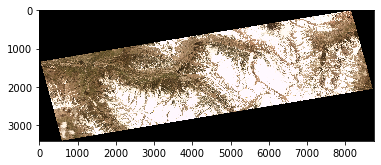

In [47]:
plt.imshow(plot.reshape_as_image(ps_rgb.read([1,2,3])))